# XY-calibration (F4)

In [1]:
cd ..

/Users/Vincent/Github/FireBallPipe



| #  | Name                               | Done                     |       Comment               |
|----|------------------------------------|--------------------------|-----------------------------|
| 1  | Have a mask-detector mapping       | <input type="checkbox">  |  And send region file to zeren |
| 2  | Use the previous XY mapping        | <input type="checkbox">  | of the same mask, if never done do a new one   |
| 2.a  |Add mask rotation for F2       | <input type="checkbox">  |                             |
| 3  | Reset magnification/offset/angle   | <input type="checkbox">  |                             |
| 4  | Be sure of the slits path          | <input type="checkbox">  |  Use only regular slits, big moves, do not use slits that are seen with one line or in shadow   |
| 4.a  | Decide to use or not hysteresis compensation          | <input type="checkbox">  |  Adds ~1h in total + slight code complexity but might improve results by <1''  |
| 5  | Account from Zeren offset          | <input type="checkbox">  |                             |
| 6  | Add slits path in google drive     | <input type="checkbox">  |                             |
| 7  | Add CNES moves to google drive     | <input type="checkbox">  |                             |


In [2]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
from astropy.io import fits
from astropy import wcs, coordinates
from astropy import units as u
from astropy.wcs.utils import proj_plane_pixel_scales
from matplotlib import pyplot as plt
from astropy.table import Table, vstack 
import matplotlib.patches as patches
import unittest
from mpl_interactions import heatmap_slicer
import pandas as pd
import datetime 
# os.chdir(os.path.dirname(os.path.realpath(__file__)))
sys.path.insert(1, './Calibration')
from guider2UV.guider2UV import Guider2UV, diff_skycoord, fit_model, plot_fit
from guider2UV.MaskAstrometry import LocalScienceMaskProjector
from Calibration.mapping import Mapping

# encoder gains 2022:
CEg = 1.0187 # CEg = 1.02928 # 2018
Elg = 1.0090 # Elg = 1.00379 # 2018
print("After calibration of the encoders, El is %0.5f ''/inc and Ce is %0.5f ''/inc" %(Elg*0.092,CEg*0.01))


After calibration of the encoders, El is 0.09283 ''/inc and Ce is 0.01019 ''/inc


## initialization from last xy calib
---------------------------------
This was actually a mistake, it should slways be done from the same mask (same field center), or create a new G2UV object

In [3]:
# prerequisites:
Field = "F4"
previous_xy_mapping = "Calibration/Mappings/2022/XY/F1_prep1_XY_220710.pkl"
mask_det_map_file = "Calibration/Mappings/2022/mask_to_det_mapping/mapping-mask-det-w-2022-5-F4_-20.pkl"
target_filename = 'Calibration/Targets/2022/targets_%s.csv'%(Field)
Hysteresis_compensation = False
if input("Are you sure that you want to use Hysteresis_compensation = %s? (y/n)"%(Hysteresis_compensation))!="y":
    raise ValueError("Please be verify the value of Hysteresis_compensation")


In [5]:
# load model from previous XY calib 
G2UV = Guider2UV(filename=previous_xy_mapping)

# eventually reset the guider-scmask rotation to 0 and magnification correction to 0.
G2UV.mask_rotation = 0.0*u.arcmin
G2UV.FieldP.gamma = 1. 
G2UV.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
G2UV.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)
print(G2UV)

# if you already know the approx angular distance between guidercenter and FOVcenter, set it:
#G2UV.FOV_center_guider_coord = coordinates.SkyCoord(delta_x*u.deg, # x guider axis (x axis in guider local frame, see XYcalib figure)
#                                                    delta_y*u.deg, # y guider axis (y axis guider local frame, see XYcalib figure)
#                                                    frame = G2UV.GuiderP.localframe)

# load targets
F1 = Table.read(target_filename, format='ascii')

# load mask-UVdetector mappings
mask_det_map = Mapping(mask_det_map_file)

if input("Are you sure that these values make sense for %s: Theta=%s, center=%s? (y/n)"%(Field, G2UV.FieldP.rotation, G2UV.FieldP.center))!="y":
    raise ValueError("Please verify the initialization mapping")



FOV center angular position in guider <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39272815, 36.41856381)>): (lon, lat) in deg
    (0.18640794, -0.08284778)>
FOV center pixel position in guider [array(1378.69397987), array(218.86229257)]

Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-90.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (32.19, -5.688)>)>
    gamma: 1.0

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39272815, 36.41856381)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.392728151  36.4185638082  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024551548564194  0.00024661678545423  
NAXIS : 0  0

    mask_rotation: 0.0 arcmin
    FOV cent

## Alternative initialisation for new fields:
---------------------------------------

In [6]:

# f_ra, f_dec, f_rot = 0, 0, 0
# Field_center=coordinates.SkyCoord(f_ra * u.deg, f_dec * u.deg)
# # get FOVcenter & guider wcs from another field
# #  put pkl from a functionning mapping from another field
# G2UVother = Guider2UV(filename=previous_xy_mapping)
# FOVcenter = G2UVother.FOV_center_guider_coord
# guider_wcs = G2UVother.GuiderP.w
# G2UV = Guider2UV(Field_center=Field_center,
#                  Field_rotation= f_rot * u.deg,
#                  Field_gamma=1.0,  # platescale correction (need to update the polynomial in the MaskAstrometry.py)
#                  FOVcenter_guider_coord=FOVcenter,
#                  guider_wcs = guider_wcs,
#                  )
                 
# FNEW = Table.read(target_filename, format='ascii')
# mask_det_map = Mapping(mask_det_map_file)

# print(G2UV)

## 1-  Rotate mask carousel
## 2- Diffuse UV image

Copy the offset from [this spreadsheet step "Compute offsets with previous diffuse illumination image"](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [7]:
# This offset in X and Y should be positive if the slit position in tghe new image appears to be shifted towards the top right
diffuse_offset = np.array([2,0])
G2UV.set_detector_mapping(mask_det_map, offsets = diffuse_offset+1) #+1 offset is to account for DS9 vs python offset
direct_map = lambda w, x, y: mask_det_map.map(w, x, y) + diffuse_offset
inv_map = lambda w, x, y: mask_det_map.inv_map(w, x - diffuse_offset[0], y - diffuse_offset[1])

## 3 - Set guider at best focus          
## 4 - Align siderostat frames           
## 5 - Go to guider reference            
## 6 - Set UV/guider best focus offset   
## 7 - Rotate mask carousel              
## 8 - Through focus in UV               
## 9 - Note open-mask guider ref point   
    

## 10 - Go through the list of slits      

['23', '36', '2', '13', '32', '11',"4"]

Here we struggled to find the good path because of faint 202/206 lines and of shadow of fiber holder

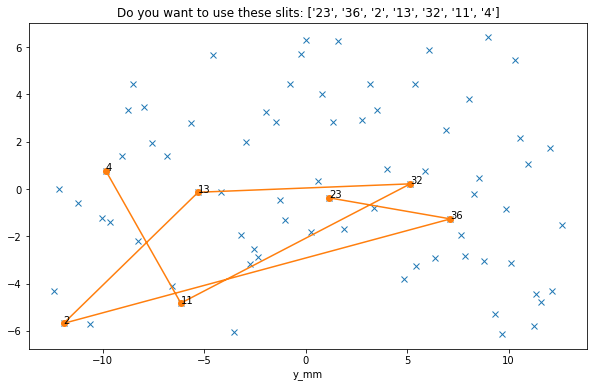

Internal-count,x_mm,y_mm,RA,DEC,ra_diff,dec_diff,angular_distance
str2,float64,float64,float64,float64,float64,float64,float64
23,1.149408,-0.37309,36.931808,0.643882,-506.0812419404365,74.80799999999968,511.5803556705188
36,7.136533,-1.264856,37.072395,0.623102,1613.8349615117118,375.41520000000037,1656.9248188703518
2,-11.936418,-5.681635,36.624081,0.51882,-562.6281328234214,-463.19400000000013,728.7654612290361
13,-5.303522,-0.138687,36.780373,0.647485,-883.6139752233256,-30.376800000000202,884.135966460028
32,5.155472,0.21635,37.025837,0.655923,955.8561607255427,420.24240000000003,1044.1573994157848
11,-6.155668,-4.825373,36.760304,0.539189,313.1789319515288,-475.4807999999997,569.3531721058029
4,-9.854999,0.771802,36.673306,0.671267,0.0,0.0,0.0


In [8]:
slits =['23', '36', '2', '13', '32', '11',"4"]
F1p = F1.to_pandas()
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# selected_slits = F1[mask.values]['Internal-count',"x_mm","y_mm","ra","dec"]
selected_slits = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1p[F1p['Internal-count'] == i],slits))))
ra,dec = "RA", "DEC"
x,y = "x_mm","y_mm"
plt.figure(figsize=(10,6))
plt.plot(F1[x],F1[y],"x")
plt.plot(selected_slits[x],selected_slits[y],"-o")
for s in selected_slits:
    plt.text(s[x],s[y],s["Internal-count"])
plt.xlabel("x_mm")
plt.xlabel("y_mm")
plt.title("Do you want to use these slits: %s"%(slits))
plt.show()

selected_slits = selected_slits['Internal-count',x,y,ra,dec]
slit_path = selected_slits# vstack((selected_slits,selected_slits[::-1]) )
slit_path["ra_diff"] = list((slit_path[ra][:-1] - slit_path[ra][1:])*np.cos(slit_path[dec][:-1]*np.pi/180)) + [0]
slit_path["dec_diff"] = list((slit_path[dec][:-1] - slit_path[dec][1:])) + [0]

slit_path["ra_diff"] *= 3600
slit_path["dec_diff"] *= 3600
slit_path["angular_distance"] = np.sqrt(slit_path["ra_diff"]** 2 + slit_path["dec_diff"]** 2)
try:
    slit_path.to_pandas().to_clipboard()
except Exception:
    pass
slit_path

The slits table has been copied. Add it to the [slit tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [10]:
moves, flags, slit_coords = G2UV.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation)
moves = pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"])#,dtype=[("EL",float),("CE",float),("UV_image",float)])
# assert moves.sum(axis=0)[0] <0.1
# assert moves.sum(axis=0)[1] <0.1
moves["UV_image"] = moves["UV_image"].astype(bool)
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

# slit_path['lon'] = [s.lon.deg*3600 for s in slits_coord]
# slit_path['lat'] =  [s.lat.deg*3600 for s in slits_coord]
# slit_path
print("(They have been copied to clipboard, paste it in the spreadsheet)")
moves.to_clipboard()
moves 
if ~Hysteresis_compensation:
    print("Carefull, with Hysteresis_compensation==%s the last move to return to the guider is not given. You just need to do -∑all moves"%(Hysteresis_compensation))
    print("You should then add EL=%0.4f and CE=%0.4f"%(moves.sum(axis=0)[0],moves.sum(axis=0)[1]))


slit position in mm on mask: [ 1.149408 -0.37309 ]
slit position in mm on mask: [ 7.136533 -1.264856]
slit position in mm on mask: [-11.936418  -5.681635]
slit position in mm on mask: [-5.303522 -0.138687]
slit position in mm on mask: [5.155472 0.21635 ]
slit position in mm on mask: [-6.155668 -4.825373]
slit position in mm on mask: [-9.854999  0.771802]

targets local coords in siderostat local frame:
EL: 318.4 arcsec ; CE: 192.4 arcsec
EL: 280.6 arcsec ; CE: 440.2 arcsec
EL: 93.2 arcsec ; CE: -349.1 arcsec
EL: 328.4 arcsec ; CE: -74.6 arcsec
EL: 343.4 arcsec ; CE: 358.2 arcsec
EL: 129.5 arcsec ; CE: -109.8 arcsec
EL: 367.0 arcsec ; CE: -262.9 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)
Carefull, with Hysteresis_compensation==False the last move to return to the guider is not given. You just need to do -∑all moves
You should then add EL=367.0160 and CE=-262.9210


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

Copy below the observed slits position from the [slit tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [11]:
slits_coord_obs_det = np.array([
[ 2003.28  ,	815.70],
[ 1946.4278  ,	366.6895],
[ 1655.4181  ,	1806.5215],
[ 2019.965  ,	1299.2635],
[ 2044.314  ,	516.54041],
[ 1707.477  ,	1366.6448],
[ 2085.6851,	1638.469]]) 

valid = np.isfinite(slits_coord_obs_det[:,0])
obs_wave = 0.2139 # 0.20255
print("wave: ", obs_wave)
slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
# slits_valid = slits[valid]
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
slits_coord_obs

if input("Are you sure you computed the barycenter on the line %s? Remember that it's better to use 206 line to probe a bigger part of the detector. It might require gain and longer exposure though. Be sure to always compute the centroid on the same line. (y/n)"%(obs_wave))!="y":
    raise ValueError("Please change obs_wave parameter (c)")


wave:  0.2139


### look at siderostat frame hysteresis 

In [13]:
if Hysteresis_compensation:
    mid  = len(slits_coord_obs_det)//2
    pair_diff = slits_coord_obs_det[:mid] - slits_coord_obs_det[::-1][:mid]
    moves_sign  = np.sign(moves[2:mid+2])
    pair_diff_signed = pair_diff * moves_sign
    valid = np.arange(len(moves_sign))#[0,2,3,4]
    fig, (ax0,ax1) = plt.subplots(1,2)
    ax0.plot(pair_diff_signed[valid,0],'*-')
    ax0.set_title("El pair diff")
    ax0.set_ylabel("El arcsec")
    ax1.plot(pair_diff_signed[valid,1],'*-')
    ax1.set_title("Ce pair diff")
    ax1.set_ylabel("Ce arcsec")
    fig.suptitle("Hysteresis analysis")
    fig.tight_layout()


## 11- Note open-mask guider ref point
## 12- Update model with observed slit positions

In [14]:
slits_coord_obs_det
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )


Fitting rotation, translation and magnification
gamma: 1.0236473517829268
theta: -1.292306120464457 arcmin
dx: 4.576888627189566 arcsec
dy: 142.8539530606342 arcsec
variances: [6.29416330e-04 2.16377395e+00 5.21677896e-01 5.21677896e-01]

residuals in arcsec: [[  0.53473804   2.23734649]
 [ -7.24849468   6.67579775]
 [  2.8178547   -3.3315457 ]
 [  2.96590484   3.29930054]
 [ -4.99758926   2.96446839]
 [  5.92758636 -11.84536747]]
max residual in EL,CE 7.2, 11.8 arcsec
mean residual in EL,CE 4.6, 6.1 arcsec


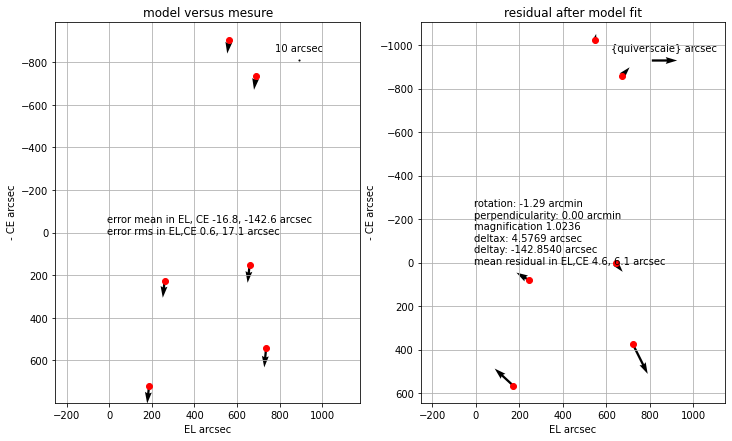

After updating:
    mask_rotation: -1.292306120464457 arcmin
    FOV center in guider: 1398.9585124448668 x 365.5147912402476 pix = 691.4023624259573 arcsec x -162.70317331587498 arcsec arcsec
    mask_magnification correction: 1.0236473517829268  
    


In [15]:
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
G2UVcor, residuals = G2UV.update_model(slits_coord_valid[1:], slits_coord_obs[1:], plot=True, figsize=(12,7))#, labels=slits_valid


### check updating without fitting magnification

In [16]:
G2UVtest=G2UV.copy()
G2UVtest.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
G2UVtest.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)
G2UVtest.FieldP.gamma = 1.
print(G2UVtest)


Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-90.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (32.19, -5.688)>)>
    gamma: 1.0

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39272815, 36.41856381)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.392728151  36.4185638082  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024551548564194  0.00024661678545423  
NAXIS : 0  0

    mask_rotation: 0.0 arcmin
    FOV center in guider: 1378.693979871492x218.8622925672349 pix



Fitting rotation, translation and magnification
gamma: 1.0232833033079378
theta: -2.0637580783996947 arcmin
dx: 4.437276448568153 arcsec
dy: 143.25463394034085 arcsec
variances: [6.11843078e-04 2.10336157e+00 5.00674651e-01 5.00674651e-01]

residuals in arcsec: [[  1.9657011   -1.71084236]
 [ -0.01330166   2.84150477]
 [ -7.2949686    6.7729117 ]
 [  2.47269373  -3.13469606]
 [  2.4098009    3.81370921]
 [ -5.181121     3.22448209]
 [  5.64119552 -11.80706935]]
max residual in EL,CE 7.3, 11.8 arcsec
mean residual in EL,CE 4.3, 5.7 arcsec


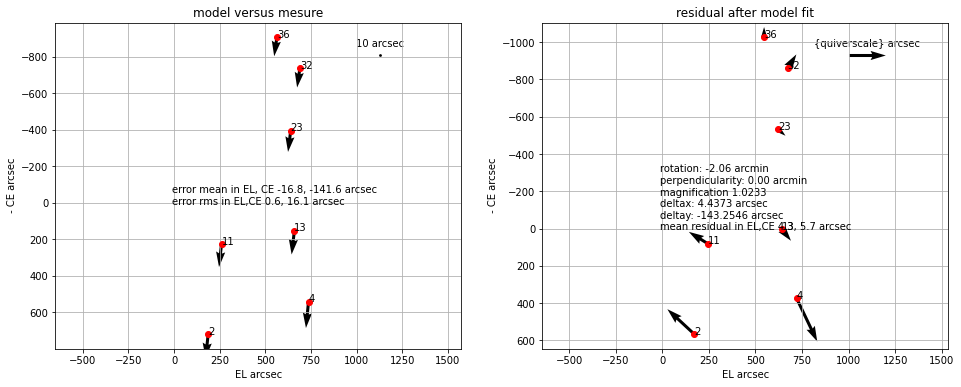

After updating:
    mask_rotation: -2.0637580783996947 arcmin
    FOV center in guider: 1398.4762460299144 x 365.8956797724491 pix = 690.9515191289703 arcsec x -162.34450625985818 arcsec arcsec
    mask_magnification correction: 1.0232833033079378  
    


In [17]:
G2UVcor_test, residuals = G2UVtest.update_model(slits_coord_valid, slits_coord_obs, labels=slits, plot=True, figsize=(16,6), gamma=True)


### save corrected model for future use (eg redo the calib on same field)

In [18]:
G2UVcor.save(filename="Calibration/Mappings/2022/XY/F4_XY_220715.pkl")

Dumping to Calibration/Mappings/2022/XY/F4_XY_220715.pkl


## 13 - Rotate carousel to science mask
## 14 - Note open-mask guider ref point
## 15 - Check corrected model through science mask

slit position in mm on mask: [ 1.149408 -0.37309 ]
slit position in mm on mask: [ 7.136533 -1.264856]
slit position in mm on mask: [-11.936418  -5.681635]
slit position in mm on mask: [-5.303522 -0.138687]
slit position in mm on mask: [5.155472 0.21635 ]
slit position in mm on mask: [-6.155668 -4.825373]
slit position in mm on mask: [-9.854999  0.771802]

targets local coords in siderostat local frame:
EL: 326.5 arcsec ; CE: 129.0 arcsec
EL: 287.8 arcsec ; CE: 385.5 arcsec
EL: 96.7 arcsec ; CE: -432.4 arcsec
EL: 336.7 arcsec ; CE: -147.2 arcsec
EL: 351.9 arcsec ; CE: 300.6 arcsec
EL: 134.0 arcsec ; CE: -183.9 arcsec
EL: 376.2 arcsec ; CE: -342.5 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)


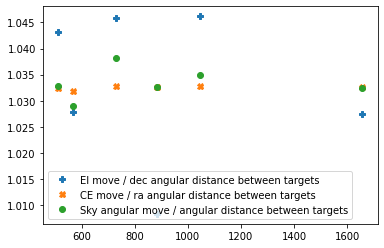

Internal-count,x_mm,y_mm,RA,DEC,ra_diff,dec_diff,angular_distance,EL,CE,El_sky,Cel_sky,Frame_angular_distance,frame_divided_sky,EL_dec_ratio,CE_ra_ratio
str2,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
23,1.149408,-0.37309,36.931808,0.643882,-506.0812419404365,74.80799999999968,511.5803556705188,-38.67384827530935,256.46926318699184,-78.04382581957427,522.5304768171771,528.3265448104445,1.0327342302226925,-1.0432550772587772,-1.0325031507069307
36,7.136533,-1.264856,37.072395,0.623102,1613.8349615117118,375.41520000000037,1656.9248188703518,-191.14369153626237,-817.9613289080033,-385.7279695201774,-1666.5144115171659,1710.5719365944726,1.032377520762044,-1.0274703036003259,-1.0326424022665293
2,-11.936418,-5.681635,36.624081,0.51882,-562.6281328234214,-463.19400000000013,728.7654612290361,240.04887870678175,285.21942123876227,484.4186372302855,581.1060488318542,756.5352973160051,1.0381053131142304,-1.0458223492322556,-1.03284214729133
13,-5.303522,-0.138687,36.780373,0.647485,-883.6139752233256,-30.376800000000202,884.135966460028,15.177643667795222,447.8251349700239,30.628484921610752,912.3989299879266,912.9128718183937,1.0325480542020984,-1.008285432356619,-1.0325763914692792
32,5.155472,0.21635,37.025837,0.655923,955.8561607255427,420.24240000000003,1044.1573994157848,-217.86721088123724,-484.5181314555316,-439.65603155833674,-987.1572410275,1080.6372400572964,1.0349371087749053,-1.0461962704342462,-1.0327466428402765
11,-6.155668,-4.825373,36.760304,0.539189,313.1789319515288,-475.4807999999997,569.3531721058029,242.15797739260208,-158.615622309298,488.67479837827096,-323.16346889296375,585.8649043909162,1.0290008611422032,-1.0277487511131287,-1.0318812535671469


In [19]:
moves, flags, slit_coords = G2UVcor.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
moves = Table.from_pandas(pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"]))
print("(They have been copied to clipboard, paste it in the spreadsheet)")
# moves.to_clipboard()
moves

new_cat = slit_path[:6]
new_cat["EL"] = moves["EL"][1:]
new_cat["CE"] = moves["CE"][1:]

new_cat["El_sky"] = new_cat["EL"]  * 2 * Elg 
new_cat["Cel_sky"] = new_cat["CE"] * 2 * CEg 
new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# new_cat
# new_cat.to_pandas().to_clipboard()

plt.figure()
plt.plot(new_cat["angular_distance"],-new_cat["EL_dec_ratio"],"P",label="El move / dec angular distance between targets")
plt.plot(new_cat["angular_distance"],-new_cat["CE_ra_ratio"],"X",label="CE move / ra angular distance between targets")
plt.plot(new_cat["angular_distance"],new_cat["frame_divided_sky"],"o",label="Sky angular move / angular distance between targets")
plt.legend()
plt.show()
new_cat#["ra_diff","dec_diff","El_sky","Cel_sky","frame_divided_sky","EL_dec_ratio","CE_ra_ratio"]#,"EL_moves","CE_moves"


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

Here we just wanted to do another try to verify that the least square gives consistent results

Fitting rotation, translation and magnification
gamma: 0.9907190063552016
theta: 5.199286407697351 arcmin
dx: 6.47584039462077 arcsec
dy: 0.20600990158452986 arcsec
variances: [6.29416330e-04 2.16377395e+00 5.21677896e-01 5.21677896e-01]

residuals in arcsec: [[ 2.14345731 -0.63718189]
 [-1.4729248   4.3142004 ]
 [-0.28627211 -3.76349203]
 [ 1.48003037  3.30289086]
 [-3.9158646   3.74503777]
 [ 2.05157384 -6.9614551 ]]
max residual in EL,CE 3.9, 7.0 arcsec
mean residual in EL,CE 2.2, 4.2 arcsec


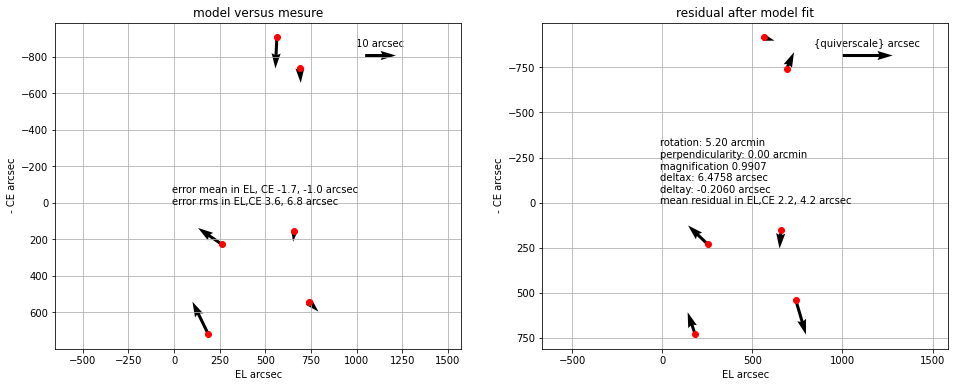

After updating:
    mask_rotation: 3.9069802872328943 arcmin
    FOV center in guider: 1399.2648803572893 x 368.49732464566944 pix = 691.7073759757741 arcsec x -159.94143168270693 arcsec arcsec
    mask_magnification correction: 1.0141468872165147  
    


(<guider2UV.guider2UV.Guider2UV at 0x7fc8d13a0e80>,
 array([[ 5.95404808e-04, -1.76994970e-04],
        [-4.09145779e-04,  1.19838900e-03],
        [-7.95200316e-05, -1.04541445e-03],
        [ 4.11119548e-04,  9.17469683e-04],
        [-1.08774017e-03,  1.04028827e-03],
        [ 5.69881621e-04, -1.93373753e-03]]))

In [20]:
slits_coord_obs_det = np.array([
[2015.5591,  	931.45115  ],
[1958.5063  ,	467.6615  ],
[1665.4307  ,	1955.4355  ],
[2034.4282 ,	1432.4388  ],
[2057.2718 ,	620.85921  ],
[1715.4736 ,	1503.1555  ],
[2102.354,  	1784.8877  ]]) 

slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
G2UVcor.update_model(slits_coord_valid[1:], slits_coord_obs[1:], plot=True, figsize=(16,6))#, labels=slits_valid





## 16 - Note science-mask guider ref point
## 17 - Go through the Star sequence 
 [29, 34, 18, 14]
we did not have the time to do this because G2UV was not well

In [21]:
G2UVcor.FieldP.center = 36.9049, 0.65245
star_target_path = "Calibration/Targets/2022/GuidingStars/F4_guidingstars.fits"
# il faut que le centre soit bien defini à l'arcseconde pres.
G2UVcor.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(36.9049*u.deg, 0.65245*u.deg), rotation=0.0*u.arcmin, gamma=1)


F1_stars = Table.read(star_target_path, format='fits').to_pandas()

stars = [29, 34, 18, 14]
selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves
# stars_path = vstack((selected_stars,selected_stars[::-1]) )
# selected_stars['lon'] = [s.lon.deg*3600 for s in stars_coord]
# selected_stars['lat'] =  [s.lat.deg*3600 for s in stars_coord]
# print("(They have been copied to clipboard, paste it in the spreadsheet)")
# star_moves.to_clipboard()
# star_moves




targets local coords in siderostat local frame:
EL: -102.8 arcsec ; CE: 225.0 arcsec
EL: -124.2 arcsec ; CE: 289.5 arcsec
EL: 129.7 arcsec ; CE: 31.5 arcsec
EL: 57.5 arcsec ; CE: 13.6 arcsec

siderostat moves sequence: 


,EL,CE,Image
0,-102.800313,224.998137,1.0
1,-21.350777,64.486499,1.0
2,253.891218,-258.010438,1.0
3,-72.210784,-17.885178,1.0


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [22]:
selection = selected_stars['Internal count',
 'RA',
 'DEC',
 'X',
 'Y',
 'GAIA gband',
 'SDSS gband',
 'SDSS rband',
 'Xguider',
 'Yguider']
# selection=vstack((selection,selection[::-1]))
selection.add_row(["-99",-99,-99,640,540,-99,-99,-99,-99,-99])
selection.to_pandas().to_clipboard()
selection

Internal count,RA,DEC,X,Y,GAIA gband,SDSS gband,SDSS rband,Xguider,Yguider
int64,float64,float64,float64,float64,int64,int64,int64,float64,float64
29,36.987137,0.402799,3.499382,-10.623502,10,--,--,375.60643978519715,274.037723163956
34,37.023638,0.390844,5.052622,-11.132199,9,--,--,329.09823563737774,119.62777354437654
18,36.877561,0.53311,-1.163312,-5.078307,--,12,11,905.7629054456784,724.3865249427333
14,36.867454,0.492628,-1.593376,-6.800959,--,13,12,743.471574722354,767.263365496059
-99,-99.0,-99.0,640.0,540.0,-99,-99,-99,-99.0,-99.0


The stars table has been copied. Add it to the [stars tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)


## 18 - Through focus guide star 1
## 19 - Track mask to guider changes
------------------------------------------------------